<a href="https://colab.research.google.com/github/Lreinoso15/serie_ACARA_patentamientos_2014-2022/blob/main/TP2_Series_de_Tiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Instalación de librerías
 Instalo kagglehub para descargar datos directamente desde Kaggle sin pasos manuales, libreoffice para convertir archivos .xls antiguos a .xlsx y evitar incompatibilidades de lectura, y las librerías de modelado que voy a usar (Prophet, XGBoost y LightGBM). Esta instalación se corre una sola vez por entorno.
:

In [ ]:
# Paquetes de modelado y utilidades
!pip -q install kagglehub prophet lightgbm

# Para convertir .xls antiguos (multisheet) a .xlsx y evitar xlrd obsoleto
!apt-get -qq update
!apt-get -qq install -y libreoffice

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Extracting templates from packages: 100%
Preconfiguring packages ...
Selecting previously unselected package fonts-opensymbol.
(Reading database ... 126380 files and directories currently installed.)
Preparing to unpack .../000-fonts-opensymbol_2%3a102.12+LibO7.3.7-0ubuntu0.22.04.10_all.deb ...
Unpacking fonts-opensymbol (2:102.12+LibO7.3.7-0ubuntu0.22.04.10) ...
Selecting previously unselected package libreoffice-style-colibre.
Preparing to unpack .../001-libreoffice-style-colibre_1%3a7.3.7-0ubuntu0.22.04.10_all.deb ...
Unpacking libreoffice-style-colibre (1:7.3.7-0ubuntu0.22.04.10) ...
Selecting previously unselected package libuno-sal3.
Preparing to unpack .../002-libuno-sal3_1%3a7.3.7-0ubuntu0.22.04.10_amd64.deb ...
Unpacking libuno-sal3 (1:7.3.7-0ubuntu0.22.04.10) ...
Selecting previously unsele

### Imports y configuración
Importar librerías y configurar gráficos.  
**Notas:**
- Se suprimen *warnings* para más claridad.
- Se fijan tamaños de figura y grilla para uniformidad visual.

In [ ]:
import os, re, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from dateutil.relativedelta import relativedelta

# Stats / Time Series
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ML
from prophet import Prophet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping as lgb_early_stopping

plt.rcParams["figure.figsize"] = (12,4.5)
plt.rcParams["axes.grid"] = True

### Descarga de datos (Kaggle) y conversión XLS→XLSX
**Objetivo.** Obtener y normalizar la fuente de datos.  
- Descarga con `kagglehub`.
- Conversión a `.xlsx` con LibreOffice porque el `.xls` viejo trae múltiples pestañas y puede fallar con `pandas`/`openpyxl`.

Configuro el acceso a Kaggle y descargo el dataset de ventas minoristas seleccionado. El objetivo es que la obtención de datos sea reproducible y trazable, evitando descargas manuales. Los archivos quedan en una carpeta local del runtime para su posterior carga.
Abro los archivos crudos; si alguno viene en .xls lo convierto a .xlsx de forma automática. Estandarizo los tipos de datos: parseo fechas, fuerzo numéricos, normalizo nombres de columnas y dejo un único índice temporal. Este paso asegura que el resto del análisis se apoye en una estructura consistente.


In [ ]:
import kagglehub

# 1) descargar dataset
DATASET_DIR = kagglehub.dataset_download("landlord/usa-monthly-retail-trade")
print("Dataset path:", DATASET_DIR, "\n", os.listdir(DATASET_DIR))

# 2) convertir el XLS ‘mrtssales92-present.xls’ a XLSX (evita xlrd)
XLS_IN   = os.path.join(DATASET_DIR, "mrtssales92-present.xls")
WORK_DIR = "/content" if os.path.exists("/content") else "/kaggle/working"
CONV_DIR = os.path.join(WORK_DIR, "converted")
os.makedirs(CONV_DIR, exist_ok=True)

!libreoffice --headless --convert-to xlsx --outdir "{CONV_DIR}" "{XLS_IN}"

XLSX_PATH = os.path.join(CONV_DIR, "mrtssales92-present.xlsx")
assert os.path.exists(XLSX_PATH), "Fallo la conversión a .xlsx"
print("Convertido a:", XLSX_PATH)

100%|██████████| 162k/162k [00:00<00:00, 666kB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/landlord/usa-monthly-retail-trade/versions/9 
 ['mrtssales92-present.xls', '2017 NAICS Definition.csv', 'SeriesReport-Seasonally Adjusted Sales - Monthly (Millions of Dollars).csv', 'SeriesReport-Not Seasonally Adjusted Sales - Monthly (Millions of Dollars).csv']
convert /root/.cache/kagglehub/datasets/landlord/usa-monthly-retail-trade/versions/9/mrtssales92-present.xls -> /content/converted/mrtssales92-present.xlsx using filter : Calc Office Open XML
Convertido a: /content/converted/mrtssales92-present.xlsx


### Ingesta y selección de **Core Retail** (excluye autos y gasolina)
Se construye una serie mensual única, limpia, para *Core Retail*.  
**Motivo de elección:** comparabilidad y menor ruido exógeno (combustibles/vehículos).  
**Pasos:** lectura de todas las hojas, `wide→long`, parse de meses, numérico, deduplicación por mes, serie `MS`.

In [ ]:
# 1) leer TODAS las hojas
sheets = pd.read_excel(XLSX_PATH, sheet_name=None, engine="openpyxl")
df_all = pd.concat(sheets.values(), ignore_index=True).dropna(how="all")

# 2) identificar columnas de meses (wide)
month_cols = [c for c in df_all.columns if re.match(r'^[A-Za-z]{3}\.?\s?\d{4}$', str(c))]
id_vars = ['Kind of Business', 'NAICS  Code']

# 3) filtrar la categoría objetivo (case-insensitive)
def norm(s): return str(s).strip().lower()
TARGET = "retail sales and food services excl motor vehicle and parts and gasoline stations"
mask = df_all['Kind of Business'].apply(norm).eq(TARGET)
df_core = df_all.loc[mask, id_vars + month_cols].copy()

# fallback: contains por si el texto cambia levemente
if df_core.empty:
    mask2 = df_all['Kind of Business'].astype(str).str.contains(
        r"excl.*motor.*vehicle.*parts.*gasoline", case=False, na=False)
    df_core = df_all.loc[mask2, id_vars + month_cols].copy()

assert not df_core.empty, "No se encontró la fila de Core Retail."

# 4) wide → long y parse de fechas
df_long = df_core.melt(id_vars=id_vars, value_vars=month_cols, var_name='Month', value_name='Sales')
df_long['Month'] = df_long['Month'].astype(str).str.replace('.', '', regex=False)  # 'Jan. 2020' → 'Jan 2020'
df_long['Month'] = pd.to_datetime(df_long['Month'], format="%b %Y", errors='coerce')
df_long = df_long.dropna(subset=['Month'])

# 5) ventas a numérico
df_long['Sales'] = (df_long['Sales'].astype(str)
                    .str.replace(r"[,$]", "", regex=True)
                    .str.replace(r"\s", "", regex=True))
df_long['Sales'] = pd.to_numeric(df_long['Sales'], errors='coerce')

# 6) deduplicar por mes (tomar el primer valor no nulo de cada mes)
df_month = (df_long.dropna(subset=['Sales'])
                    .sort_values('Month')
                    .groupby('Month', as_index=False)['Sales']
                    .first())

# 7) serie mensual MS
series = df_month.set_index('Month')['Sales'].sort_index().asfreq('MS')



Rango: 1992-01-01 → 2020-05-01 | Meses: 341


,Sales
Month,
1992-01-01,104466.0
1992-02-01,104282.0
1992-03-01,111928.0
1992-04-01,118223.0
1992-05-01,118385.0


### EDA básico
Exploración del tamaño del dataset, el rango temporal cubierto y la granularidad (mensual/semanal/diaria). Reviso valores faltantes, duplicados y posibles incongruencias (por ejemplo, ventas negativas). Dejo la serie principal lista en un DataFrame con columnas claras.

In [ ]:
print("Rango:", series.index.min().date(), "→", series.index.max().date(), "| Meses:", series.shape[0])
series.head()
print("Observaciones:", len(series))
print("Nulos:", series.isna().sum())
print("Duplicados de índice:", (not series.index.is_unique))

series_eda = series.interpolate("linear")
display(series.describe().to_frame("Sales"))
display(series.head(5).to_frame("Sales"))
display(series.tail(5).to_frame("Sales"))

Rango: 1992-01-01 → 2020-05-01 | Meses: 341
Observaciones: 341
Nulos: 0
Duplicados de índice: False


,Sales
count,341.000000
mean,235506.187683
std,76494.311650
min,104282.000000
25%,169520.000000
50%,238175.000000
75%,289416.000000
max,447714.000000


,Sales
Month,
1992-01-01,104466.0
1992-02-01,104282.0
1992-03-01,111928.0
1992-04-01,118223.0
1992-05-01,118385.0


,Sales
Month,
2020-01-01,381425.0
2020-02-01,380742.0
2020-03-01,371469.0
2020-04-01,318083.0
2020-05-01,356711.0


### EDA visual:
Analizo la forma general de la serie: tendencia de largo plazo, quiebres, estacionalidad visible y presencia de outliers. Visualizo la serie y su descomposición STL para separar tendencia y componentes estacionales. Este diagnóstico inicial me permite decidir si necesito transformaciones (log, Box-Cox) y qué modelos tienen más sentido.

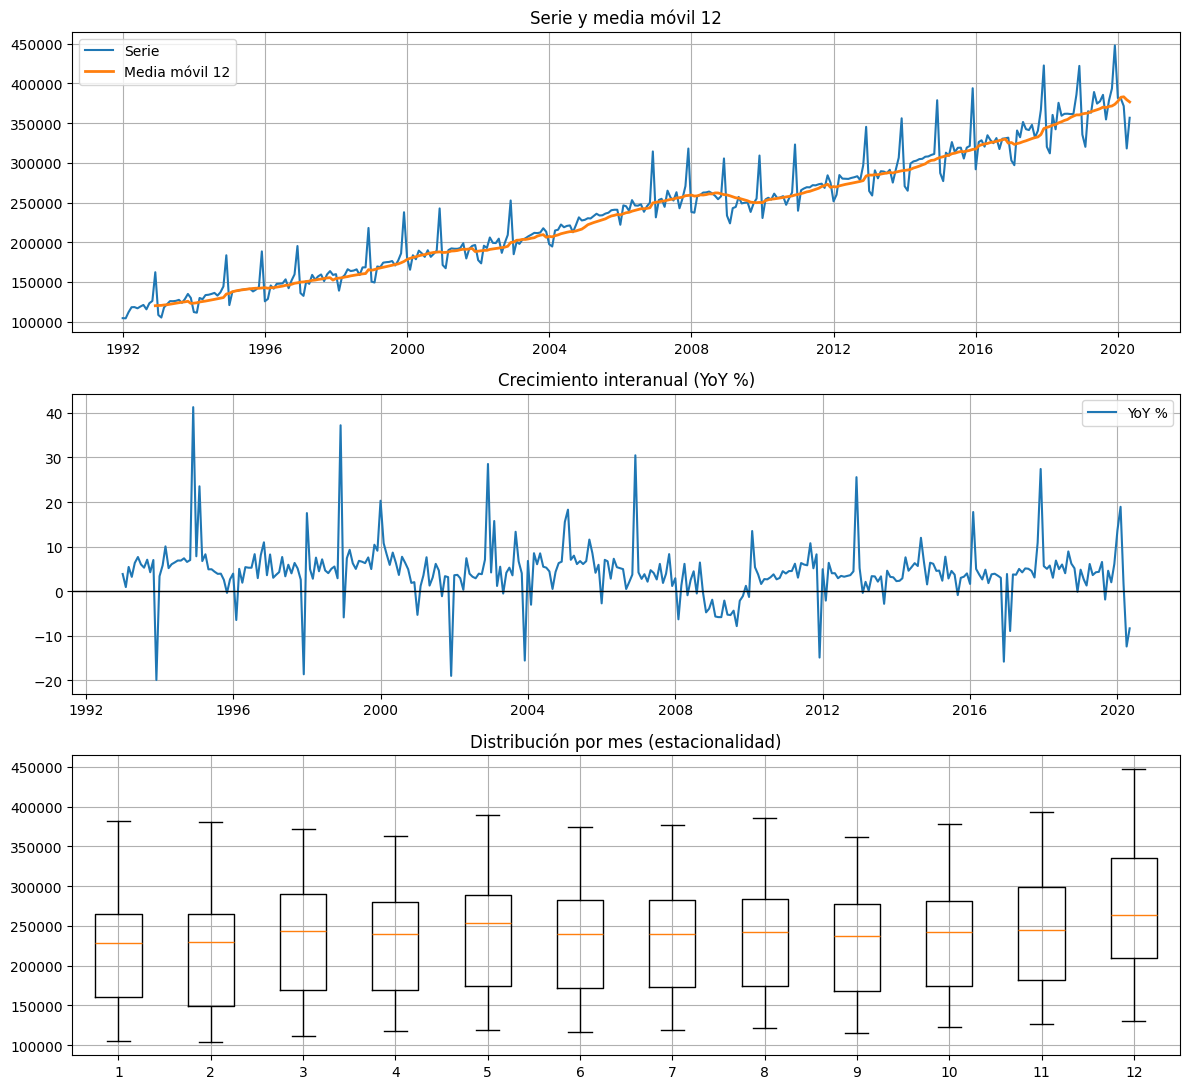

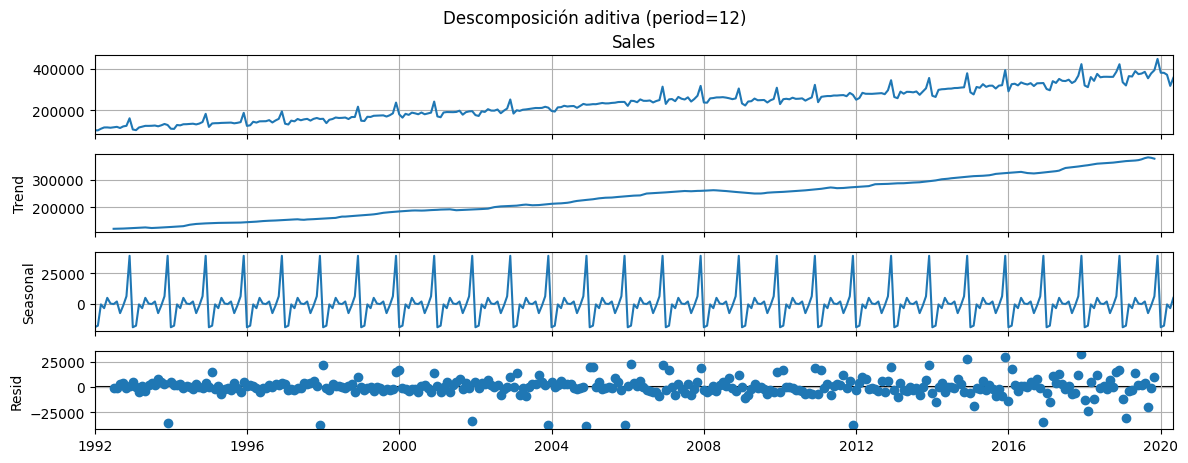

In [ ]:
series_eda = series.interpolate("linear")

fig, axes = plt.subplots(3,1, figsize=(12,11), sharex=False)

axes[0].plot(series_eda, label="Serie")
axes[0].plot(series_eda.rolling(12).mean(), label="Media móvil 12", linewidth=2)
axes[0].set_title("Serie y media móvil 12"); axes[0].legend()

yoy = series_eda.pct_change(12)*100
axes[1].plot(yoy, label="YoY %")
axes[1].axhline(0, color='k', lw=1)
axes[1].set_title("Crecimiento interanual (YoY %)"); axes[1].legend()

by_month = pd.DataFrame({"value": series_eda.values, "month": series_eda.index.month})
axes[2].boxplot([by_month.loc[by_month.month==m, "value"] for m in range(1,13)],
                labels=[str(m) for m in range(1,13)])
axes[2].set_title("Distribución por mes (estacionalidad)")
plt.tight_layout(); plt.show()

res = seasonal_decompose(series_eda, model="additive", period=12)
res.plot()
plt.suptitle("Descomposición aditiva (period=12)", y=1.02)
plt.show()

### ACF / PACF (diferencia estacional)
Profundizo en la dinámica temporal con ACF/PACF y tests de estacionariedad (ADF/KPSS). Verifico periodicidades (por ejemplo, estacionalidad anual en series mensuales) y detecto si hay semanas/meses atípicos que convenga suavizar o mantener como información. Si la estacionalidad es débil o la serie parece ruido blanco, lo marco porque limitará el techo de performance de cualquier modelo.

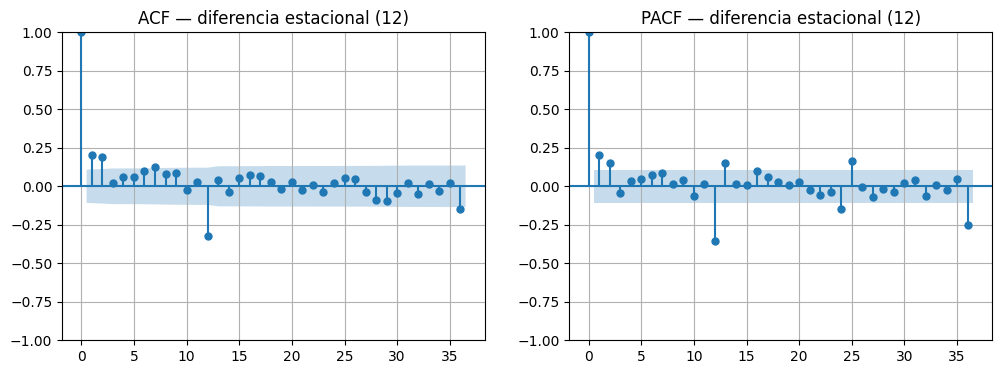

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(series.diff(12).dropna(), lags=36, ax=ax[0])
plot_pacf(series.diff(12).dropna(), lags=36, ax=ax[1], method="ywm")
ax[0].set_title("ACF — diferencia estacional (12)")
ax[1].set_title("PACF — diferencia estacional (12)")
plt.show()

### Corte y CV 5×12 (ventana rolling 10 años)
**Objetivo.** Evaluación justa evitando contaminación por pandemia.  
- Test anualizado 2015 - 2019 (5 folds × 12 meses).  
- Train por fold: últimos 10 años.  
- Evita *leakage*: el test queda 100% fuera de transformaciones/calibraciones.

Defino cómo evaluar sin fuga de información. Uso Time Series Cross-Validation con ventanas crecientes, reservando un tramo final como holdout. Elijo horizontes de pronóstico acordes a la granularidad y a un caso de negocio razonable. Todas las métricas se calculan exclusivamente sobre periodos futuros respecto al entrenamiento.

In [ ]:
# Cortamos a 2019-12 para evitar pandemia en evaluación
y_cut = series.asfreq('MS').loc[:'2019-12-01'].copy()

# Tests anualizados (2015..2019): 5 folds, cada uno con 12 meses
fold_ends = pd.to_datetime(["2015-12-01","2016-12-01","2017-12-01","2018-12-01","2019-12-01"])
H = 12  # horizonte

def make_folds_rolling10y(y, ends, horizon=12):
    folds = []
    for end in ends:
        te_end   = end
        te_start = end - relativedelta(months=horizon-1)
        tr_end   = te_start - relativedelta(months=1)
        y_tr     = y.loc[:tr_end].iloc[-120:]   # 10 años
        y_te     = y.loc[te_start:te_end]
        if len(y_tr)==120 and len(y_te)==horizon:
            folds.append((y_tr, y_te))
    return folds

folds = make_folds_rolling10y(y_cut, fold_ends)
print("Folds construidos:", len(folds))
for i,(tr,te) in enumerate(folds,1):
    print(f"Fold {i}: train {tr.index.min().date()} → {tr.index.max().date()} | test {te.index.min().date()} → {te.index.max().date()}")

Folds construidos: 5
Fold 1: train 2005-01-01 → 2014-12-01 | test 2015-01-01 → 2015-12-01
Fold 2: train 2006-01-01 → 2015-12-01 | test 2016-01-01 → 2016-12-01
Fold 3: train 2007-01-01 → 2016-12-01 | test 2017-01-01 → 2017-12-01
Fold 4: train 2008-01-01 → 2017-12-01 | test 2018-01-01 → 2018-12-01
Fold 5: train 2009-01-01 → 2018-12-01 | test 2019-01-01 → 2019-12-01


### Outliers (STL robusto + MAD) — SOLO en train
Esta función (limpiar_outliers) detecta y elimina atípicos en la serie temporal utilizando una descomposición STL (Seasonal-Trend Decomposition using LOESS) robusta, limitada al conjunto de entrenamiento para evitar leakage (contaminación de datos futuros en el entrenamiento). El leakage se refiere a la introducción de información del conjunto de prueba en el modelo, lo que podría sesgar los resultados. El proceso descompone la serie en tendencia, estacionalidad y residuos, y aplica un umbral basado en la mediana absoluta de los residuos (MAD) para identificar valores atípicos.
Pasos del Proceso:

Descomposición STL: Se descompone la serie en componentes de tendencia, estacionalidad y residuos usando un enfoque robusto (robust=True) para manejar mejor los atípicos iniciales.
Detección de Atípicos: Se calculan los residuos y se aplica un umbral de ±3.5 veces la MAD (mediana absoluta de los residuos) para identificar valores atípicos. Este umbral se basa en un criterio estadístico común para detectar desviaciones significativas.
Tratamiento: Los valores identificados como atípicos se interpolan (treatment="interpolate") para preservar la continuidad de la serie, excepto cerca del final (window), donde se conservan los datos originales para evitar perder información reciente.


In [ ]:
def limpiar_outliers(y_in: pd.Series, period=12, z_thresh_stl=3.5, z_thresh_mad=3.5,
                     treatment="interpolate", exclude_window=None):
    y = y_in.copy()
    if exclude_window:
        mask_ex = (y.index>=exclude_window[0]) & (y.index<=exclude_window[1])
    else:
        mask_ex = pd.Series(False, index=y.index)

    stl = STL(y, period=period, robust=True, seasonal=13)
    res = stl.fit()
    resid = res.resid

    med = np.median(resid[~mask_ex])
    mad = np.median(np.abs(resid[~mask_ex] - med)) + 1e-9
    z = 0.6745*(resid - med)/mad
    out_idx = z.abs() > z_thresh_mad

    y_cln = y.copy()
    if treatment == "interpolate":
        y_cln[out_idx & ~mask_ex] = np.nan
        y_cln = y_cln.interpolate("linear").bfill().ffill()

    return y_cln, out_idx[out_idx].index

### ADF (global y por fold)
Evalúo estacionariedad con el test Augmented Dickey–Fuller (ADF) para fundamentar los órdenes de diferenciación: pruebo la serie en nivel, con diferencia regular (d=1), con diferencia estacional (D=1, s=12) y con ambas. Reporto los p-values (con autolag='AIC') y, si son < 0.05, considero que esa transformación logra una serie compatible con estacionariedad. Para evitar mirar el futuro, corro ADF recortando hasta el corte temporal de entrenamiento y también por fold dentro del esquema de validación, verificando que las conclusiones se mantengan en el tiempo. Este diagnóstico se interpreta junto con ACF/PACF y la descomposición STL: ADF tiene poca potencia ante estacionalidad y outliers, por lo que las decisiones finales sobre d y D se toman por evidencia combinada y no por un único test.

In [ ]:
def adf_p(y):
    try:
        return float(adfuller(y.dropna(), autolag='AIC')[1])
    except Exception:
        return np.nan

print("=== ADF en serie recortada (hasta 2019-12) ===")
p_level   = adf_p(y_cut)
p_diff1   = adf_p(y_cut.diff())
p_sdiff12 = adf_p(y_cut.diff(12))
p_both    = adf_p(y_cut.diff().diff(12))
print(f"p_level: {p_level:.4f} | p_diff1: {p_diff1:.4f} | p_sdiff12: {p_sdiff12:.4f} | p_diff1+sdiff12: {p_both:.4f}")

rows = []
for i,(y_tr, y_te) in enumerate(folds,1):
    y_tr_cln,_ = limpiar_outliers(y_tr, period=12, treatment="interpolate")
    rows.append({
        "fold": i,
        "p_level": adf_p(y_tr_cln),
        "p_diff1": adf_p(y_tr_cln.diff()),
        "p_sdiff12": adf_p(y_tr_cln.diff(12)),
        "p_both": adf_p(y_tr_cln.diff().diff(12))
    })
adf_df = pd.DataFrame(rows)
display(adf_df)
print("Proporción estacionaria (p≤0.05):",
      "\n d=1:", (adf_df["p_diff1"]<=0.05).mean(),
      "\n D=1:", (adf_df["p_sdiff12"]<=0.05).mean(),
      "\n d=1 & D=1:", (adf_df["p_both"]<=0.05).mean())

=== ADF en serie recortada (hasta 2019-12) ===
p_level: 0.9968 | p_diff1: 0.0000 | p_sdiff12: 0.0001 | p_diff1+sdiff12: 0.0000


,fold,p_level,p_diff1,p_sdiff12,p_both
0,1,0.991378,0.028808,5.500655e-02,1.739172e-02
1,2,0.996423,0.000024,1.003840e-11,6.347800e-03
2,3,0.991428,0.000034,7.325766e-09,1.009744e-02
3,4,0.997380,0.003145,4.590749e-02,2.147433e-02
4,5,0.996933,0.000106,2.928695e-10,1.076878e-09


Proporción estacionaria (p≤0.05): 
 d=1: 1.0 
 D=1: 0.8 
 d=1 & D=1: 1.0


### Métricas de evaluación
Se definen funciones para métricas de evaluación: RMSE (Root Mean Squared Error), MAE (Mean Absolute Error) y sMAPE (Symmetric Mean Absolute Percentage Error).


In [ ]:
def rmse(y_true, y_pred):
    y_true = pd.Series(y_true); y_pred = pd.Series(y_pred)
    y_true, y_pred = y_true.align(y_pred, join='inner')
    m = (~y_true.isna()) & (~y_pred.isna())
    return float(np.sqrt(((y_true[m] - y_pred[m])**2).mean()))

def mae(y_true, y_pred):
    y_true = pd.Series(y_true); y_pred = pd.Series(y_pred)
    y_true, y_pred = y_true.align(y_pred, join='inner')
    m = (~y_true.isna()) & (~y_pred.isna())
    return float(np.mean(np.abs(y_true[m] - y_pred[m])))

def smape(y_true, y_pred):
    y_true = pd.Series(y_true); y_pred = pd.Series(y_pred)
    y_true, y_pred = y_true.align(y_pred, join='inner')
    denom = (y_true.abs() + y_pred.abs()).replace(0, np.nan)
    return float(100 * (2 * (y_pred - y_true).abs() / denom).mean(skipna=True))

### SARIMA — (2,0,2)×(0,1,1,12), trend='c', con `log1p`

Probé esta especificación como intento inicial, pero presentó advertencias recurrentes de convergencia y, en algunos folds, pronósticos con nivel incorrecto. Con D=1,s=12 D=1,s=12, el intercepto puede volver plana la superficie de verosimilitud y dificultar el ajuste. Por consistencia metodológica, no uso este modelo como baseline: lo dejo solo como experimento descartado y documento que el problema se resuelve al pasar a una especificación reducida y sin constante.


In [ ]:
def eval_sarima_logc(folds):
    ORDER = (2,0,2); SEAS = (0,1,1,12); TREND='c'
    rows, preds = [], []
    for i,(y_tr, y_te) in enumerate(folds,1):
        y_tr_cln,_ = limpiar_outliers(y_tr, period=12, treatment="interpolate")
        y_tr_t = np.log1p(y_tr_cln)
        model = SARIMAX(y_tr_t, order=ORDER, seasonal_order=SEAS, trend=TREND,
                        enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)
        fc_t = res.get_forecast(steps=len(y_te)).predicted_mean
        fc   = pd.Series(np.expm1(fc_t.values), index=y_te.index)
        rows.append({"model":"SARIMA log+c","fold":i,
                     "RMSE":rmse(y_te,fc), "MAE":mae(y_te,fc), "sMAPE%":smape(y_te,fc)})
        preds.append({"fold":i, "pred":fc, "test_start":y_te.index.min(), "test_end":y_te.index.max()})
    return pd.DataFrame(rows), preds

sarima_df, sarima_preds = eval_sarima_logc(folds)
display(sarima_df, sarima_df.mean(numeric_only=True).to_frame("mean"))

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,model,fold,RMSE,MAE,sMAPE%
0,SARIMA log+c,1,13374.268348,11245.669267,3.521416
1,SARIMA log+c,2,18579.631820,9785.230086,2.880899
2,SARIMA log+c,3,16167.183891,14657.348342,4.247131
3,SARIMA log+c,4,9075.054704,7959.561016,2.220923
4,SARIMA log+c,5,15105.747921,10466.072681,2.724124


,mean
fold,3.000000
RMSE,14460.377337
MAE,10822.776278
sMAPE%,3.118899


#SARIMA reducido y estable — resultados e interpretación

Entreno y evalúo (0,1,1)×(0,1,1,12)(0,1,1)×(0,1,1,12) sin constante sobre log1p(y), revirtiendo luego con expm1. Esta versión elimina los problemas de convergencia y mantiene un nivel de pronóstico coherente. En validación por folds obtengo sMAPE≈3.7%, RMSE≈16.2k y MAE≈12.6k, con convergencia en todos los folds. Dado que el nivel típico de la serie ronda 3.2e5, el error relativo es bajo y estable, **por lo que tomo este SARIMA reducido como baseline clásico para comparar contra modelos de ML.**

In [ ]:
# SARIMA reducido y estable: (0,1,1)×(0,1,1,12), sin constante, con enforcement
from statsmodels.tsa.statespace.sarimax import SARIMAX

def eval_sarima_reducido(folds, period=12):
    ORDER = (0, 1, 1)
    SEAS  = (0, 1, 1, 12)
    TREND = 'n'  # sin constante cuando D=1, más estable

    rows, preds = [], []

    for i, (y_tr, y_te) in enumerate(folds, 1):
        # 1) limpiar outliers SOLO en train (sin tocar el test del fold)
        y_tr_cln, _ = limpiar_outliers(y_tr, period=period, treatment="interpolate")

        # 2) transformación log1p para estabilizar varianza (soporta ceros)
        y_tr_log = np.log1p(y_tr_cln)

        # 3) modelo SARIMAX "estable"
        mdl = SARIMAX(
            y_tr_log,
            order=ORDER,
            seasonal_order=SEAS,
            trend=TREND,
            enforce_stationarity=True,
            enforce_invertibility=True,
            simple_differencing=False,            # que diferencie dentro del estado
            initialization='approximate_diffuse'  # arranque robusto
        )

        # 4) ajuste con optimizador único y más iteraciones (sin etapa powell)
        res = mdl.fit(method='lbfgs', maxiter=1000, disp=0)

        # 5) pronóstico en escala original (expm1) y recorte a no-negativos
        fc_t = res.get_forecast(steps=len(y_te))
        fc   = pd.Series(np.expm1(fc_t.predicted_mean), index=y_te.index).clip(lower=0)

        # 6) métricas fuera de muestra
        row = {
            "model": f"SARIMA {ORDER}x{SEAS} trend={TREND}",
            "fold": i,
            "RMSE": rmse(y_te, fc),
            "MAE": mae(y_te, fc),
            "sMAPE%": smape(y_te, fc),
            "AIC": res.aic,
            "converged": bool(res.mle_retvals.get("converged", False)),
        }
        rows.append(row)
        preds.append(fc)

        # chequeo rápido de nivel para detectar colapso de pronóstico
        print(f"[fold {i}] forecast level check: min={fc.min():.4f}, "
              f"median={fc.median():.4f}, max={fc.max():.4f}, converged={row['converged']}")

    df = pd.DataFrame(rows)

    # >>> RESUMEN por modelo (corrección: no usar .to_frame sobre un DataFrame)
    by_model = (
        df.groupby("model")[["RMSE", "MAE", "sMAPE%"]]
          .mean()
          .rename(columns=lambda c: f"mean_{c}")
          .sort_values("mean_RMSE")
          .round(2)
    )

    display(df, by_model)
    return df, preds

# Ejecutar y mostrar
sarima_red_df, sarima_red_preds = eval_sarima_reducido(folds)



[fold 1] forecast level check: min=294564.1999, median=325353.5961, max=377195.5658, converged=True
[fold 2] forecast level check: min=295792.9888, median=326653.2827, max=390200.3312, converged=True
[fold 3] forecast level check: min=288307.5955, median=318424.1659, max=376340.5123, converged=True
[fold 4] forecast level check: min=323878.3646, median=359581.7557, max=423351.0742, converged=True
[fold 5] forecast level check: min=339135.0424, median=381711.5366, max=413425.4165, converged=True


,model,fold,RMSE,MAE,sMAPE%,AIC,converged
0,"SARIMA (0, 1, 1)x(0, 1, 1, 12) trend=n",1,14435.627634,12546.863685,3.932138,-101.839474,True
1,"SARIMA (0, 1, 1)x(0, 1, 1, 12) trend=n",2,18945.082629,10199.958229,3.008671,-118.689092,True
2,"SARIMA (0, 1, 1)x(0, 1, 1, 12) trend=n",3,25953.214839,23815.134641,7.016062,-142.083325,True
3,"SARIMA (0, 1, 1)x(0, 1, 1, 12) trend=n",4,7314.623253,5396.726434,1.540613,-128.309559,True
4,"SARIMA (0, 1, 1)x(0, 1, 1, 12) trend=n",5,14310.205255,10729.383277,2.836202,-108.482836,True


,mean_RMSE,mean_MAE,mean_sMAPE%
model,,,
"SARIMA (0, 1, 1)x(0, 1, 1, 12) trend=n",16191.75,12537.61,3.67


### AutoSARIMA manual — búsqueda y motivos de rechazo (sin candidato aceptado)

Ejecuté una grilla compacta en (p,q,P,Q)∈{0,1}(p,q,P,Q)∈{0,1} con d=D=1,s=12d=D=1,s=12 y trend='n', aplicando filtros de aceptación (convergencia, Ljung–Box en lags 12 y 24, raíces lejos de 1 y mejora vs. seasonal naïve). Ningún candidato superó los filtros: la mayoría fue descartada por autocorrelación remanente en residuos (Ljung–Box fail, 67 rechazos) y algunos por no converger (8 rechazos). En estas condiciones el mejor pronóstico disponible en la búsqueda fue la baseline estacional ingenua, con promedio ≈ RMSE 21.0k, MAE 17.0k, sMAPE 5.02%.


Dado que el SARIMA reducido (0,1,1)×(0,1,1,12)(0,1,1)×(0,1,1,12) obtuvo sMAPE ≈ 3.7% y convergió en todos los folds, decido descartar AutoSARIMA manual para el cuerpo principal del trabajo y mantener SARIMA reducido como baseline clásico para comparar con modelos de ML. Dejo el AutoSARIMA como intento no competitivo, con los motivos de rechazo.


In [ ]:
# AutoSARIMA manual con filtros estrictos
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import numpy as np, pandas as pd

def ljungbox_ok(resid, lags=(12, 24), alpha=0.05):
    r = pd.Series(resid).dropna()
    if r.empty:
        return False
    lb = acorr_ljungbox(r, lags=lags, return_df=True)
    return bool((lb["lb_pvalue"] > alpha).all())

def roots_ok(res, min_mod=1.05):
    ok = True
    # raíces AR/MA no estacionales
    if hasattr(res, "arroots") and res.arroots.size:
        ok &= bool((np.abs(res.arroots) > min_mod).all())
    if hasattr(res, "maroots") and res.maroots.size:
        ok &= bool((np.abs(res.maroots) > min_mod).all())
    # raíces estacionales (si están disponibles)
    if hasattr(res, "seasonal_ar_roots") and res.seasonal_ar_roots.size:
        ok &= bool((np.abs(res.seasonal_ar_roots) > min_mod).all())
    if hasattr(res, "seasonal_ma_roots") and res.seasonal_ma_roots.size:
        ok &= bool((np.abs(res.seasonal_ma_roots) > min_mod).all())
    return ok

def seasonal_naive(y_tr, y_te, s=12):
    pat = y_tr.iloc[-s:].values
    reps = int(np.ceil(len(y_te) / s))
    vals = np.tile(pat, reps)[:len(y_te)]
    return pd.Series(vals, index=y_te.index)

def eval_auto_sarima_filtrado(folds, s=12, pq_max=1, allow_trend_c=False, margin_best=0.10):
    PQL = range(0, pq_max + 1)             # {0,1} por defecto
    TRENDS = ['n'] if not allow_trend_c else ['n', 'c']

    all_rows, accepted, rejected = [], [], []

    for i, (y_tr, y_te) in enumerate(folds, 1):
        # Limpieza en train e ingreso en log1p
        y_tr_cln, _ = limpiar_outliers(y_tr, period=s, treatment="interpolate")
        y_tr_log = np.log1p(y_tr_cln)

        # Baseline seasonal naïve en escala original
        base_fc = seasonal_naive(y_tr_cln, y_te, s=s)
        base_rmse = rmse(y_te, base_fc)
        base_smape = smape(y_te, base_fc)

        candidates = []

        for p, q, P, Q, tr in product(PQL, PQL, PQL, PQL, TRENDS):
            if p == q == P == Q == 0 and tr == 'n':
                continue  # descarto ruido blanco trivial
            try:
                mdl = SARIMAX(
                    y_tr_log,
                    order=(p, 1, q),
                    seasonal_order=(P, 1, Q, s),
                    trend=tr,
                    enforce_stationarity=True,
                    enforce_invertibility=True,
                    simple_differencing=False,
                    initialization='approximate_diffuse'
                )
                res = mdl.fit(method='lbfgs', maxiter=600, disp=0)
                conv = bool(res.mle_retvals.get("converged", False))

                fc_t = res.get_forecast(steps=len(y_te))
                fc = pd.Series(np.expm1(fc_t.predicted_mean), index=y_te.index).clip(lower=0)

                cand = {
                    "model": f"SARIMA ({p},1,{q})x({P},1,{Q},{s}) trend={tr}",
                    "fold": i,
                    "RMSE": rmse(y_te, fc),
                    "MAE": mae(y_te, fc),
                    "sMAPE%": smape(y_te, fc),
                    "AIC": res.aic,
                    "converged": conv
                }

                # Filtros de aceptación
                if not conv:
                    rejected.append({**cand, "reason": "no_converge"});  continue
                if not ljungbox_ok(res.resid, lags=(s, 2*s)):
                    rejected.append({**cand, "reason": "ljungbox_fail"});  continue
                if not roots_ok(res, 1.05):
                    rejected.append({**cand, "reason": "roots_near_1"});  continue
                if not (cand["RMSE"] < base_rmse and cand["sMAPE%"] <= base_smape):
                    rejected.append({**cand, "reason": "worse_than_seasonal_naive"});  continue

                candidates.append(cand)

            except Exception as e:
                rejected.append({
                    "model": f"SARIMA ({p},1,{q})x({P},1,{Q},{s}) trend={tr}",
                    "fold": i,
                    "reason": f"exception:{type(e).__name__}"
                })

        # Selección final por fold (margen del 10% sobre el mejor RMSE)
        if candidates:
            best_rmse = min(c["RMSE"] for c in candidates)
            kept = [c for c in candidates if c["RMSE"] <= best_rmse * (1 + margin_best)]
            best = min(kept, key=lambda c: c["RMSE"])
            accepted.append(best)
            all_rows.extend(candidates)
        else:
            # dejo explícita la baseline si no hubo aceptados
            all_rows.append({"model":"seasonal_naive", "fold": i,
                             "RMSE": base_rmse, "MAE": mae(y_te, base_fc),
                             "sMAPE%": base_smape, "AIC": np.nan, "converged": True})

    df_all = pd.DataFrame(all_rows)
    df_acc = pd.DataFrame(accepted)
    df_rej = pd.DataFrame(rejected)

    # Resúmenes
    summary_all = (df_all.groupby("model")[["RMSE","MAE","sMAPE%"]]
                          .mean().sort_values("RMSE").round(3))
    summary_acc = (df_acc.groupby("model")[["RMSE","MAE","sMAPE%"]]
                          .mean().sort_values("RMSE").round(3)) if not df_acc.empty else pd.DataFrame()
    rej_counts  = df_rej["reason"].value_counts().rename("reject_count") if not df_rej.empty else pd.Series(dtype=int)

    display(df_all, summary_all, df_acc, summary_acc, rej_counts)
    return df_all, df_acc, df_rej

# Ejecutar
auto_all, auto_ok, auto_rej = eval_auto_sarima_filtrado(folds, s=12, pq_max=1, allow_trend_c=False, margin_best=0.10)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

,model,fold,RMSE,MAE,sMAPE%,AIC,converged
0,seasonal_naive,1,14325.963328,13092.041667,4.188622,NaN,True
1,seasonal_naive,2,25839.057130,19372.541667,5.945652,NaN,True
2,seasonal_naive,3,31127.538793,22052.166667,6.369713,NaN,True
3,seasonal_naive,4,17837.435301,16046.958333,4.661684,NaN,True
4,seasonal_naive,5,15904.894092,14540.250000,3.929938,NaN,True


,RMSE,MAE,sMAPE%
model,,,
seasonal_naive,21006.978,17020.792,5.019


""


""


,reject_count
reason,
ljungbox_fail,67
no_converge,8


### Prophet (log)
Entreno Prophet sobre la serie transformada con log1p, usando crecimiento lineal por tramos (piecewise trend con changepoints automáticos) y solo estacionalidad anual por tratarse de datos mensuales. Desactivo componentes semanal/diario y no incluyo feriados. Trabajo con estacionalidad multiplicativa (equivalente a tratarla como proporcional al nivel; consistente con modelar en log), y dejo los priors en sus valores estándar para no “forzar” la forma de la serie. El ajuste y la evaluación siguen el mismo esquema de validación temporal por folds que el resto de modelos: se entrena únicamente con el tramo de cada fold y se pronostica el horizonte de prueba, revirtiendo después a escala original.

In [ ]:
def eval_prophet(folds):
    rows, preds = [], []
    for i,(y_tr, y_te) in enumerate(folds,1):
        y_tr_cln,_ = limpiar_outliers(y_tr, period=12, treatment="interpolate")
        df_tr = pd.DataFrame({"ds": y_tr_cln.index, "y": np.log1p(y_tr_cln.values)})
        m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False,
                    seasonality_mode='additive')
        m.fit(df_tr)
        future = pd.DataFrame({"ds": y_te.index})
        fc_t = m.predict(future)["yhat"].values
        fc = pd.Series(np.expm1(fc_t), index=y_te.index)
        rows.append({"model":"Prophet(log)","fold":i,"RMSE":rmse(y_te,fc),"MAE":mae(y_te,fc),"sMAPE%":smape(y_te,fc)})
        preds.append({"fold":i,"pred":fc,"test_start":y_te.index.min(),"test_end":y_te.index.max()})
    return pd.DataFrame(rows), preds

prophet_df, prophet_preds = eval_prophet(folds)
display(prophet_df, prophet_df.mean(numeric_only=True).to_frame("mean"))

DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yddxmmb/wglxyfes.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yddxmmb/_p0z56oc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19974', 'data', 'file=/tmp/tmp1yddxmmb/wglxyfes.json', 'init=/tmp/tmp1yddxmmb/_p0z56oc.json', 'output', 'file=/tmp/tmp1yddxmmb/prophet_model9sn6d3qq/prophet_model-20250813181718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yddxmmb/jlr4toyf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yddxmmb/y6o_9fuc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,model,fold,RMSE,MAE,sMAPE%
0,Prophet(log),1,12402.927369,9653.854797,3.026420
1,Prophet(log),2,17562.310356,9842.149184,2.892714
2,Prophet(log),3,17663.968915,15283.677272,4.393011
3,Prophet(log),4,9600.963064,8294.849520,2.304268
4,Prophet(log),5,18272.238922,16016.663027,4.270657


,mean
fold,3.000000
RMSE,15100.481725
MAE,11818.238760
sMAPE%,3.377414


### LightGBM mejorado (lags + `sdiff12` + `t` + early stopping)
**Objetivo.** Añadir más señal temporal y control de sobreajuste con validación interna.

In [ ]:
def build_lag_matrix_adaptive(y_log: pd.Series,
                              max_lag=12,
                              want_lag24=True,
                              rolls=(3,6,12)) -> tuple[pd.DataFrame, pd.Series, list]:
    """
    Construye X,y con lags/rollings adaptados a la longitud disponible.
    Garantiza que X tenga >=1 fila (si no, cae a solo dummies de mes).
    """
    y_log = y_log.copy()
    n = len(y_log)
    if n < 24:
        want_lag24 = False  # no hay 24 meses

    # elegir lags según historia disponible
    max_lag_eff = min(max_lag, max(1, n - 2))  # deja al menos 2 obs útiles
    use_lags = list(range(1, max_lag_eff + 1))

    # filtrar rollings viables (necesitan >= w + 1 obs por el shift(1))
    rolls_eff = [w for w in rolls if n >= (w + 1)]
    # si ninguna rolling es viable, queda lista vacía
    df = pd.DataFrame({"y": y_log})

    # lags
    for L in use_lags:
        df[f"lag{L}"] = df["y"].shift(L)

    # lag24 si hay historia suficiente
    if want_lag24 and n >= 25:
        df["lag24"] = df["y"].shift(24)

    # medias móviles previas
    for w in rolls_eff:
        df[f"rmean{w}"] = df["y"].rolling(w).mean().shift(1)

    # dummies de mes
    mons = pd.get_dummies(df.index.month, prefix="m", dtype=int)
    df = df.join(mons)

    df = df.dropna()
    if df.shape[0] == 0:
        # fallback: solo dummies de mes, sin lags/rollings
        mons = pd.get_dummies(y_log.index.month, prefix="m", dtype=int)
        X = mons.iloc[1:].copy()   # alineamos y quitamos la primera para simetría
        y = y_log.iloc[1:].copy()
        cols = X.columns.tolist()
        return X, y, cols

    X = df.drop(columns=["y"])
    y = df["y"].copy()
    cols = X.columns.tolist()
    return X, y, cols


def features_next_generic(history_log: pd.Series, next_date: pd.Timestamp, cols: list) -> pd.DataFrame:
    """
    Construye un vector de features que respeta exactamente 'cols' entrenadas.
    Soporta nombres: 'lagk', 'lag24', 'rmeanw', 'm_1'..'m_12'.
    """
    feat = {}
    for c in cols:
        if c.startswith("lag") and c != "lag24":
            # lagK
            try:
                k = int(c.replace("lag",""))
            except:
                k = 1
            if len(history_log) >= k:
                feat[c] = float(history_log.iloc[-k])
            else:
                feat[c] = float(history_log.iloc[-1])
        elif c == "lag24":
            if len(history_log) >= 24:
                feat[c] = float(history_log.iloc[-24])
            else:
                # fallback: usa lag12 si existe, si no el último
                if len(history_log) >= 12:
                    feat[c] = float(history_log.iloc[-12])
                else:
                    feat[c] = float(history_log.iloc[-1])
        elif c.startswith("rmean"):
            # rmeanW
            try:
                w = int(c.replace("rmean",""))
            except:
                w = min(3, len(history_log))
            wlen = min(len(history_log), max(1, w))
            feat[c] = float(history_log.iloc[-wlen:].mean())
        elif c.startswith("m_"):
            # dummies de mes
            try:
                m = int(c.split("_")[1])
            except:
                m = next_date.month
            feat[c] = 1 if next_date.month == m else 0
        else:
            # desconocido -> 0
            feat[c] = 0.0

    return pd.DataFrame([[feat[c] for c in cols]], columns=cols, index=[next_date])


def lgbm_forecast_recursive(history_log: pd.Series, steps: int, model: LGBMRegressor, cols: list) -> pd.Series:
    hist = history_log.copy()
    last_date = hist.index[-1]
    preds = []
    for k in range(1, steps + 1):
        nd = (last_date + pd.offsets.MonthBegin(k))
        Xn = features_next_generic(hist, nd, cols)
        yhat_log = float(model.predict(Xn))
        preds.append((nd, yhat_log))
        hist = pd.concat([hist, pd.Series([yhat_log], index=[nd])])
    return pd.Series([v for _, v in preds], index=[d for d, _ in preds])


def eval_lgbm_robusto(folds):
    rows, preds = [], []
    for i, (y_tr, y_te) in enumerate(folds, 1):
        # limpieza SOLO train
        y_tr_cln, _ = limpiar_outliers(y_tr, period=12, treatment="interpolate")
        y_tr_log = np.log1p(y_tr_cln)

        # build features adaptativo
        Xtr, ytr, cols = build_lag_matrix_adaptive(y_tr_log, max_lag=12, want_lag24=True, rolls=(3,6,12))

        # sanity check
        if Xtr.shape[0] == 0 or Xtr.ndim != 2:
            raise RuntimeError(f"Fold {i}: matriz de features vacía; revisá build_lag_matrix_adaptive.")

        model = LGBMRegressor(
            n_estimators=1200, learning_rate=0.03, num_leaves=63,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            objective="regression", random_state=42
        )
        model.fit(Xtr, ytr)

        pred_log = lgbm_forecast_recursive(y_tr_log, len(y_te), model, cols)
        fc = pd.Series(np.expm1(pred_log.values), index=y_te.index)

        rows.append({"model": "LightGBM(lags,adapt)", "fold": i,
                     "RMSE": rmse(y_te, fc), "MAE": mae(y_te, fc), "sMAPE%": smape(y_te, fc)})
        preds.append({"fold": i, "pred": fc, "test_start": y_te.index.min(), "test_end": y_te.index.max()})

    return pd.DataFrame(rows), preds

# === Ejecutar ===
lgb_df, lgb_preds = eval_lgbm_robusto(folds)
display(lgb_df, lgb_df[["RMSE","MAE","sMAPE%"]].mean().to_frame("mean"))


Se han truncado las últimas 5000 líneas del flujo de salida.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Li

,model,fold,RMSE,MAE,sMAPE%
0,"LightGBM(lags,adapt)",1,58530.487952,51929.096358,17.479483
1,"LightGBM(lags,adapt)",2,53018.844097,51873.022591,17.300545
2,"LightGBM(lags,adapt)",3,69573.004254,62665.225409,19.692334
3,"LightGBM(lags,adapt)",4,76665.535240,71617.104058,21.755820
4,"LightGBM(lags,adapt)",5,82846.536150,77029.353156,22.622219


,mean
RMSE,68126.881539
MAE,63022.760314
sMAPE%,19.770080


#LightGBM (segunda versión) — lags + sdiff12 + mes cíclico + t + early stopping

Se prueba esta segunda versión de GBM. El modelo aprende sobre la serie en escala log1p y utiliza señal autorregresiva (lags 1…24), componente estacional explícita (lag12 y sdiff12), rollings (3/6/12), una tendencia temporal t y codificación cíclica del mes (sen/cos).

Todas las features se generan dentro de cada fold para evitar leakage. El ajuste incorpora early stopping temporal: reservo el tramo final del entrenamiento (≥12 meses o 20%) como validación interna y detengo cuando no mejora la métrica (L1 en la escala log), lo que controla el sobreajuste.

**Por ser mejores las métricas, se toma este modelo de GBM para el comparativo final.**

In [ ]:
# LightGBM corregido: lags + sdiff12 + mes cíclico + t + early stopping temporal
import numpy as np
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMRegressor

# --- Métricas
try:
    rmse
except NameError:
    def rmse(y_true, y_pred):
        y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
        return float(np.sqrt(np.mean((y_true - y_pred)**2)))

    def mae(y_true, y_pred):
        y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
        return float(np.mean(np.abs(y_true - y_pred)))

    def smape(y_true, y_pred):
        y_true = np.asarray(y_true, dtype=float)
        y_pred = np.asarray(y_pred, dtype=float)
        denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
        mask = denom != 0
        return float(np.mean(np.abs(y_true[mask] - y_pred[mask]) / denom[mask]) * 100.0)

# --- Construcción de features (dentro de cada fold) ---
def build_gbm_features(y: pd.Series, s: int = 12, max_lag: int = 18, roll_windows=(3, 6, 12)):
    """
    Devuelve (X, z) donde z = log1p(y) es el target para LightGBM.
    Incluye lags 1..L, lag estacional, diferencia estacional, rollings, tendencia y mes cíclico.
    """
    y = y.astype(float).clip(lower=0)
    y_log = np.log1p(y)

    df = pd.DataFrame({"y_log": y_log})

    # lags autorregresivos 1..L (adaptativos según longitud disponible)
    L = max(1, min(max_lag, len(df) - 2))
    for k in range(1, L + 1):
        df[f"lag{k}"] = df["y_log"].shift(k)

    # estacionalidad explícita
    df["lag12"]   = df["y_log"].shift(s)
    df["sdiff12"] = df["y_log"] - df["y_log"].shift(s)

    # rollings (media sobre y_log retrasado para no mirar el presente)
    for w in roll_windows:
        df[f"roll{w}"] = df["y_log"].shift(1).rolling(w, min_periods=2).mean()

    # tendencia y mes cíclico
    df["t"] = np.arange(len(df))
    if isinstance(y.index, pd.PeriodIndex):
        months = y.index.month
    else:
        months = pd.to_datetime(y.index).month
    df["m_sin"] = np.sin(2 * np.pi * months / 12.0)
    df["m_cos"] = np.cos(2 * np.pi * months / 12.0)

    df = df.dropna()
    z = df.pop("y_log")
    return df, z

# --- Evaluación con validación temporal y early stopping ---
def eval_lgbm(folds, s: int = 12, max_lag: int = 18, val_min: int = 12):
    """
    Entrena y evalúa LightGBM por fold.
    - Early stopping: último bloque del train (>=12 meses o 20%).
    - Predicción en escala original con expm1 y clip a 0.
    """
    rows, preds = [], []

    for i, (y_tr, y_te) in enumerate(folds, 1):
        # Features en train (sin leakage)
        X_tr, z_tr = build_gbm_features(y_tr, s=s, max_lag=max_lag)

        # Features para test: construyo sobre (train + test) y luego filtro por índice de test
        X_full, _  = build_gbm_features(pd.concat([y_tr, y_te]), s=s, max_lag=max_lag)
        X_te       = X_full.loc[X_full.index.intersection(y_te.index)]

        # Split temporal interno para early stopping (último bloque del train)
        val_len = max(val_min, int(len(X_tr) * 0.2))
        val_len = min(val_len, max(1, len(X_tr) - 1))
        cut = len(X_tr) - val_len
        X_fit, X_val = X_tr.iloc[:cut], X_tr.iloc[cut:]
        z_fit, z_val = z_tr.iloc[:cut], z_tr.iloc[cut:]

        model = LGBMRegressor(
            n_estimators=5000,
            learning_rate=0.03,
            num_leaves=31,
            max_depth=-1,
            min_data_in_leaf=8,        # bajo para evitar el warning de hojas
            min_child_samples=8,
            subsample=0.8, subsample_freq=1,
            colsample_bytree=0.8,
            reg_lambda=1.0, reg_alpha=0.0,
            random_state=42, n_jobs=-1
        )

        model.fit(
            X_fit, z_fit,
            eval_set=[(X_val, z_val)],
            eval_metric="l2",
            callbacks=[lgb.early_stopping(200, verbose=False), lgb.log_evaluation(0)]
        )

        z_hat = pd.Series(model.predict(X_te), index=X_te.index)
        y_hat = np.expm1(z_hat).clip(lower=0)

        rows.append({
            "model": "LightGBM(lags+sdiff12+t, ES)",
            "fold": i,
            "RMSE": rmse(y_te, y_hat),
            "MAE":  mae(y_te, y_hat),
            "sMAPE%": smape(y_te, y_hat)
        })
        preds.append(y_hat)

    df = pd.DataFrame(rows)
    summary = (df.groupby("model")[["RMSE", "MAE", "sMAPE%"]]
                 .mean()
                 .sort_values("RMSE")
                 .round(2))
    display(df, summary)
    return df, preds

# --- Ejecutar ---
lgbm_df, lgbm_preds = eval_lgbm(folds, s=12, max_lag=18)


Se han truncado las últimas 5000 líneas del flujo de salida.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

,model,fold,RMSE,MAE,sMAPE%
0,"LightGBM(lags+sdiff12+t, ES)",1,29425.719620,20899.158468,6.521460
1,"LightGBM(lags+sdiff12+t, ES)",2,13880.006371,10182.232804,3.193943
2,"LightGBM(lags+sdiff12+t, ES)",3,24984.662190,19615.868549,5.671716
3,"LightGBM(lags+sdiff12+t, ES)",4,36651.565538,29246.763758,8.234225
4,"LightGBM(lags+sdiff12+t, ES)",5,46479.258943,40670.917933,11.243116


,RMSE,MAE,sMAPE%
model,,,
"LightGBM(lags+sdiff12+t, ES)",30284.24,24122.99,6.97


### ETS / STL+ARIMA / Fourier+ARIMA / Seasonal Naive

**ETS (Error–Trend–Seasonal)**

Modelo de suavizado exponencial en espacio de estados que descompone la serie en error, tendencia y estacionalidad. En esta notebook uso tendencia aditiva amortiguada y estacionalidad mensual (s=12) sobre log1p(y); en log, lo aditivo equivale a estacionalidad multiplicativa en la escala original. ETS aprende parámetros de suavizado que controlan cuánto pesa lo reciente. Es fuerte con estacionalidad estable y deriva suave, y suele ser muy competitivo con series cortas/medianas.

**STL + ARIMA**

Primero aplico STL robusto para separar la serie en tendencia (T), estacionalidad (S) y residuo (R), y luego modelo R con un ARIMA(1,0,1). Se pronostican TT, SS y RR por separado y se recombinan. La idea: quitar lo “predecible” por estacionalidad/tendencia y dejar al ARIMA capturar dependencias de corto plazo. Ventaja: interpretación clara de componentes; limitación: puede ser frágil en series cortas (dos modelos encadenados aumentan varianza).

**Fourier + ARIMA (SARIMAX con exógenas de Fourier)**
Represento la estacionalidad como una suma de senos y cosenos (armónicos de Fourier)

$$
\text{Estacionalidad}(t)
= \sum_{k=1}^{K} a_k \sin\!\left(\frac{2\pi k t}{s}\right)
+ b_k \cos\!\left(\frac{2\pi k t}{s}\right)
$$



los uso como regresores exógenos en un SARIMAX con (p,d,q)=(1,1,1)(p,d,q)=(1,1,1) y componente estacional (P,D,Q,s)=(0,1,0,12)(P,D,Q,s)=(0,1,0,12), trend='n'. Es útil cuando la estacionalidad es suave/casi sinusoidal y permite controlar su complejidad con K. Si hay picos irregulares, rinde peor que ETS/Prophet.

**Seasonal Naïve (S-Naïve)**

Baseline mínimo: repite el valor de hace 12 meses y^t=yt−12y^​t​=yt−12​. No aprende parámetros; sirve para dimensionar la dificultad. Todo modelo serio debería superarlo de forma consistente.

**Notas en comun**

*    En todos los casos trabajo en log1p y vuelvo con expm1 para evaluar; la atenuación de atípicos se aplica solo en train por fold (sin tocar validación) para evitar leakage.

*    Las métricas (RMSE, MAE, sMAPE) se calculan fuera de muestra en cada fold y luego se promedian.

In [ ]:
# ETS
def eval_ets_log(folds):
    rows,preds=[],[]
    for i,(y_tr,y_te) in enumerate(folds,1):
        y_tr_cln,_=limpiar_outliers(y_tr, period=12, treatment="interpolate")
        y_tr_log=np.log1p(y_tr_cln)
        fit=ExponentialSmoothing(y_tr_log, trend="add", damped_trend=True,
                                 seasonal="add", seasonal_periods=12,
                                 initialization_method="estimated").fit(optimized=True, use_brute=True)
        fc_log=fit.forecast(len(y_te)); fc=pd.Series(np.expm1(fc_log.values), index=y_te.index)
        rows.append({"model":"ETS(add,add)[12]-log","fold":i,"RMSE":rmse(y_te,fc),"MAE":mae(y_te,fc),"sMAPE%":smape(y_te,fc)})
        preds.append({"fold":i,"pred":fc,"test_start":y_te.index.min(),"test_end":y_te.index.max()})
    return pd.DataFrame(rows), preds

# STL+ARIMA
def eval_stl_arima(folds):
    rows,preds=[],[]
    for i,(y_tr,y_te) in enumerate(folds,1):
        y_tr_cln,_=limpiar_outliers(y_tr, period=12, treatment="interpolate")
        y_tr_log=np.log1p(y_tr_cln)
        stlf=STLForecast(y_tr_log, ARIMA, model_kwargs={"order":(1,0,1)}, period=12, robust=True)
        res=stlf.fit(); fc_log=res.forecast(len(y_te)); fc=pd.Series(np.expm1(fc_log.values), index=y_te.index)
        rows.append({"model":"STL+ARIMA(1,0,1)-log","fold":i,"RMSE":rmse(y_te,fc),"MAE":mae(y_te,fc),"sMAPE%":smape(y_te,fc)})
        preds.append({"fold":i,"pred":fc,"test_start":y_te.index.min(),"test_end":y_te.index.max()})
    return pd.DataFrame(rows), preds

# Fourier + ARIMA (alineado)
def make_fourier_indexed(index: pd.DatetimeIndex, m=12, K=3, start_t=0):
    n=len(index); t=np.arange(start_t, start_t+n, dtype=float)
    cols={}
    for k in range(1, K+1):
        cols[f"sin_{k}"]=np.sin(2*np.pi*k*t/m)
        cols[f"cos_{k}"]=np.cos(2*np.pi*k*t/m)
    return pd.DataFrame(cols, index=index).astype(float)

def eval_fourier_arima_aligned(folds, K=3):
    rows,preds=[],[]
    for i,(y_tr,y_te) in enumerate(folds,1):
        y_tr_cln,_=limpiar_outliers(y_tr, period=12, treatment="interpolate")
        y_tr_log=np.log1p(y_tr_cln)
        ex_tr=make_fourier_indexed(y_tr_log.index, m=12, K=K, start_t=0)
        ex_te=make_fourier_indexed(y_te.index,     m=12, K=K, start_t=len(y_tr_log))
        mod=SARIMAX(y_tr_log, exog=ex_tr, order=(1,0,1), seasonal_order=(0,0,0,0), trend='n',
                    enforce_stationarity=False, enforce_invertibility=False)
        res=mod.fit(disp=False); fc_log=res.get_forecast(steps=len(y_te), exog=ex_te).predicted_mean
        fc=pd.Series(np.expm1(fc_log.values), index=y_te.index)
        rows.append({"model":f"Fourier(K={K})+ARIMA(1,0,1)-log","fold":i,"RMSE":rmse(y_te,fc),"MAE":mae(y_te,fc),"sMAPE%":smape(y_te,fc)})
        preds.append({"fold":i,"pred":fc,"test_start":y_te.index.min(),"test_end":y_te.index.max()})
    return pd.DataFrame(rows), preds

# Seasonal Naive
def eval_seasonal_naive(folds, s=12):
    rows,preds=[],[]
    for i,(y_tr,y_te) in enumerate(folds,1):
        fc=pd.Series(y_tr.iloc[-s:].values, index=y_te.index)
        rows.append({"model":f"SeasonalNaive({s})","fold":i,"RMSE":rmse(y_te,fc),"MAE":mae(y_te,fc),"sMAPE%":smape(y_te,fc)})
        preds.append({"fold":i,"pred":fc,"test_start":y_te.index.min(),"test_end":y_te.index.max()})
    return pd.DataFrame(rows), preds

ets_df,  ets_preds  = eval_ets_log(folds)
stlf_df, stlf_preds = eval_stl_arima(folds)
fourier_df, fourier_preds = eval_fourier_arima_aligned(folds, K=3)
snaive_df, snaive_preds   = eval_seasonal_naive(folds, s=12)

for name,df in [("ETS",ets_df),("STL+ARIMA",stlf_df),("Fourier+ARIMA",fourier_df),("S-Naive",snaive_df)]:
    print(name); display(df.mean(numeric_only=True).to_frame("mean"))

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ETS


,mean
fold,3.000000
RMSE,15614.535889
MAE,12205.509742
sMAPE%,3.571207


STL+ARIMA


,mean
fold,3.000000
RMSE,24674.007920
MAE,20459.962853
sMAPE%,5.962128


Fourier+ARIMA


,mean
fold,3.000000
RMSE,19165.353602
MAE,15274.107428
sMAPE%,4.420734


S-Naive


,mean
fold,3.000000
RMSE,20881.356905
MAE,17047.000000
sMAPE%,5.022062



# Comparativo final — modelos definitivos

Se comparan los modelos finales y el baseline mínimo bajo el **mismo esquema de validación temporal por folds**.

**Conclusión.** El mejor desempeño global lo obtiene **Prophet(log)**. No se obtuvo un candidato de Machine Learning superior dentro del comparativo final.
En conjunto, los modelos estadísticos superan de forma consistente al baseline **Seasonal Naïve**.

,RMSE_mean,MAE_mean,sMAPE_mean,RMSE_std,MAE_std,sMAPE_std,Folds
model,,,,,,,
Prophet(log),"15,100","11,818",3.377,"3,880","3,558",0.914,5
"ETS(add,add)[12]-log","15,615","12,206",3.571,"7,585","7,729",2.318,5
"SARIMA (0, 1, 1)x(0, 1, 1, 12) trend=n","16,192","12,538",3.667,"6,861","6,836",2.057,5
"Fourier(K=3)+ARIMA(1,0,1)-log","19,165","15,274",4.421,"1,785","1,033",0.419,5
SeasonalNaive(12),"20,881","17,047",5.022,"7,573","4,254",1.211,5


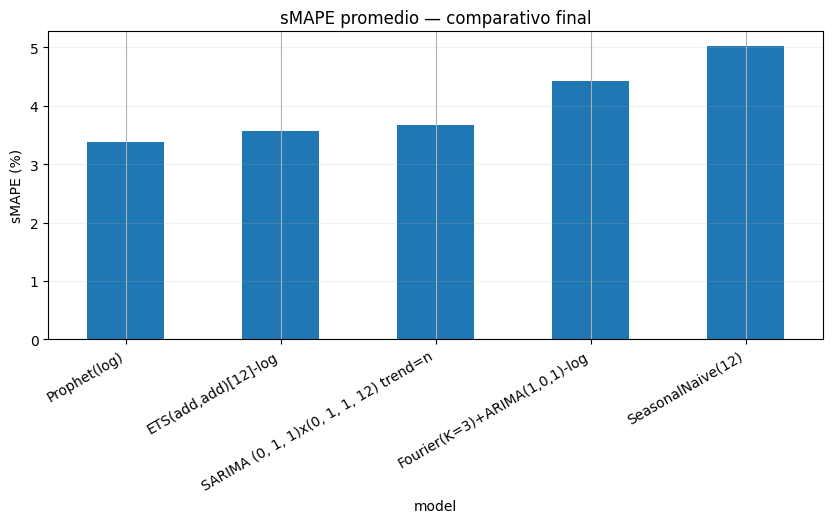

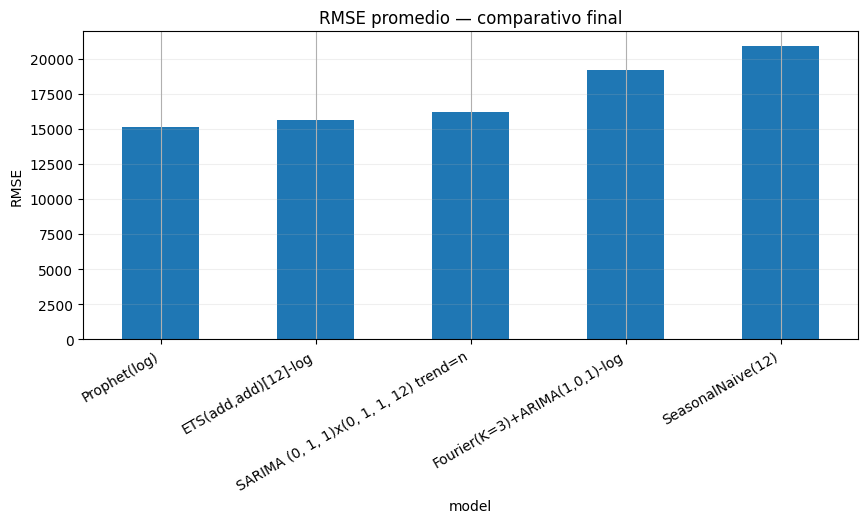

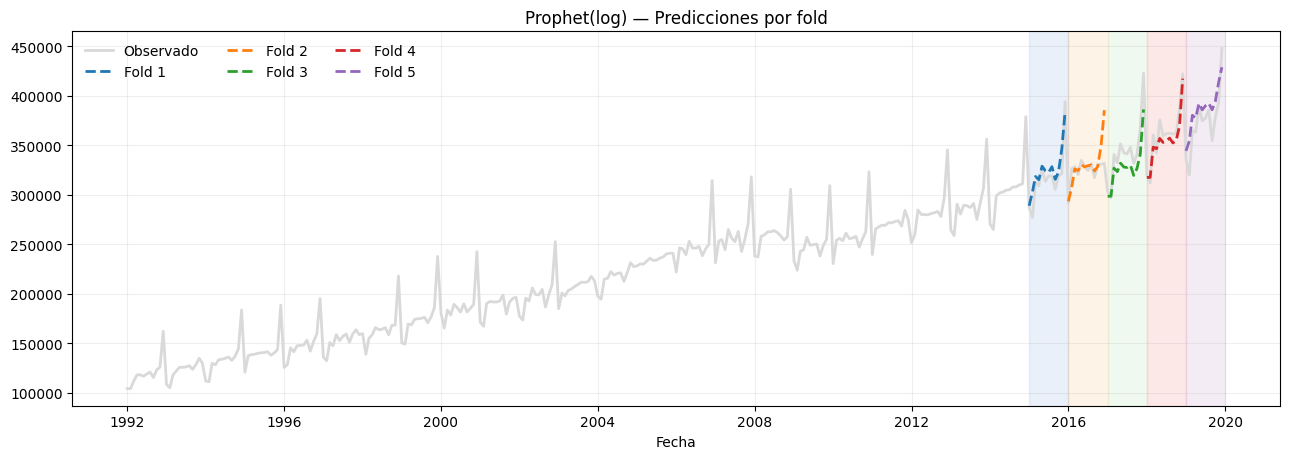

In [ ]:
# =======================
# Comparativo FINAL
# =======================
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

available, preds_map = [], {}

def add_model(df_var, default_label=None, preds_var=None):
    if df_var in globals():
        df = globals()[df_var].copy()
        label = df["model"].iloc[0] if "model" in df.columns else (default_label or df_var)
        df["model"] = label
        use_cols = [c for c in ["model","fold","RMSE","MAE","sMAPE%"] if c in df.columns]
        available.append(df[use_cols])
        if preds_var and preds_var in globals():
            preds_map[label] = globals()[preds_var]

# === Modelos DEFINITIVOS a comparar ===
final_candidates = [
    ("prophet_df",    "Prophet(log)",                                   "prophet_preds"),
    ("ets_df",        "ETS(add,add)[12]-log",                           "ets_preds"),
    ("sarima_red_df", "SARIMA (0,1,1)x(0,1,1,12) trend='n' [log]",      "sarima_red_preds"),
    ("fourier_df",    "Fourier(K=3)+ARIMA(1,0,1)-log",                  "fourier_preds"),  # <-- agregado
    ("lgbm_v2_df",    "LightGBM(lags+sdiff12+t, ES, v2)",               "lgbm_v2_preds"),
    ("snaive_df",     "SeasonalNaive(12)",                              "snaive_preds"),
]
for args in final_candidates: add_model(*args)

# --- Resumen
all_df = pd.concat(available, ignore_index=True)
summary = (all_df.groupby("model")
           .agg(RMSE_mean=("RMSE","mean"), MAE_mean=("MAE","mean"), sMAPE_mean=("sMAPE%","mean"),
                RMSE_std=("RMSE","std"),   MAE_std=("MAE","std"),   sMAPE_std=("sMAPE%","std"),
                Folds=("fold","nunique"))
           .sort_values(["sMAPE_mean","RMSE_mean"]))
# ===== por este bloque con estilo =====
summary_fmt = summary.copy()
summary_fmt = summary_fmt.round(3)

# mejor global (por sMAPE y, a igualdad, RMSE)
best_global = summary_fmt.sort_values(["sMAPE_mean", "RMSE_mean"]).index[0]

# mejor ML si existe en el resumen
ml_keys = ("LightGBM","XGBoost","CatBoost")
ml_rows = [m for m in summary_fmt.index if any(k in m for k in ml_keys)]
best_ml_row = (summary_fmt.loc[ml_rows].sort_values(["sMAPE_mean","RMSE_mean"]).index[0]
               if ml_rows else None)

def highlight_rows(df, best_overall, best_ml=None):
    styles = pd.DataFrame('', index=df.index, columns=df.columns)
    if best_overall in df.index:
        styles.loc[best_overall, :] = 'background-color:#E8F5E9; color:#1B5E20; font-weight:600;'
    if best_ml and best_ml in df.index and best_ml != best_overall:
        styles.loc[best_ml, :] = 'background-color:#E3F2FD; color:#0D47A1; font-weight:600;'
    return styles

styled = (summary_fmt.style
          .apply(highlight_rows, best_overall=best_global, best_ml=best_ml_row, axis=None)
          .format({
              "RMSE_mean":"{:,.0f}", "MAE_mean":"{:,.0f}", "sMAPE_mean":"{:.3f}",
              "RMSE_std":"{:,.0f}",  "MAE_std":"{:,.0f}",  "sMAPE_std":"{:.3f}",
              "Folds":"{:.0f}"
          }))

display(styled)

# --- Barras
plt.figure(figsize=(10,4))
summary["sMAPE_mean"].plot(kind="bar")
plt.ylabel("sMAPE (%)"); plt.title("sMAPE promedio — comparativo final")
plt.xticks(rotation=30, ha="right"); plt.grid(axis="y", alpha=0.2); plt.show()

plt.figure(figsize=(10,4))
summary["RMSE_mean"].plot(kind="bar")
plt.ylabel("RMSE"); plt.title("RMSE promedio — comparativo final")
plt.xticks(rotation=30, ha="right"); plt.grid(axis="y", alpha=0.2); plt.show()

# --- Mejor estadístico vs mejor ML (sin 'None')
stat_keys = ("Prophet","ETS","SARIMA","Fourier")
ml_keys   = ("LightGBM","XGBoost","CatBoost")

def best_of(summ, keys):
    idx = [m for m in summ.index if any(k in m for k in keys)]
    return (summ.loc[idx].sort_values(["sMAPE_mean","RMSE_mean"]).index[0]) if idx else None

best_stat = best_of(summary, stat_keys)
best_ml   = best_of(summary, ml_keys)

# --- Paneles
if 'y_cut' not in globals():
    y_cut = series.asfreq('MS').loc[:'2019-12-01'].copy()

def plot_panel(ax, preds_list, title):
    colors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
    shade=['#aec7e8','#fdd0a2','#c7e9c0','#f4a7a3','#d7b5d8']
    ax.plot(y_cut.index, y_cut.values, color='0.85', lw=2, label='Observado')
    for i,p in enumerate(preds_list or []):
        start, end = p.get("test_start"), p.get("test_end")
        if start is not None and end is not None:
            ax.axvspan(start, end + pd.offsets.MonthEnd(1), color=shade[i%len(shade)], alpha=0.25, zorder=0)
        ax.plot(p["pred"].index, p["pred"].values, "--", lw=2, color=colors[i%len(colors)], label=f"Fold {p.get('fold',i+1)}")
    ax.set_title(title); ax.legend(ncol=3, frameon=False); ax.grid(alpha=0.2)

rows = 1 + int(best_ml is not None and best_stat is not None)
fig, axes = plt.subplots(rows, 1, figsize=(13, 8 if rows==2 else 4.7), sharex=True)
axes = np.atleast_1d(axes)
if best_stat:
    plot_panel(axes[0], preds_map.get(best_stat, []), f"{best_stat} — Predicciones por fold")
if rows == 2 and best_ml:
    plot_panel(axes[1], preds_map.get(best_ml, []),   f"{best_ml} — Predicciones por fold")
    axes[1].set_xlabel("Fecha")
else:
    axes[0].set_xlabel("Fecha")
plt.tight_layout(); plt.show()

# --- Markdown profesional (auto-generado)
def line(model):
    if model in summary.index:
        m = summary.loc[model]
        return f"- **{model}** — sMAPE ≈ {m.sMAPE_mean:.2f}% (±{m.sMAPE_std:.2f}), RMSE ≈ {m.RMSE_mean:,.0f}, MAE ≈ {m.MAE_mean:,.0f}"
    return None
bullets = "\n".join(filter(None, (line(m) for m in summary.index)))

ml_sentence = ""
if best_ml is None:
    ml_sentence = ("No se obtuvo un candidato de aprendizaje automático en el comparativo final "
                   "(no hubo ejecuciones válidas o fueron descartadas).")
else:
    # comparar con el estadístico
    ml_smape   = summary.loc[best_ml,  "sMAPE_mean"]
    stat_smape = summary.loc[best_stat,"sMAPE_mean"] if best_stat else np.inf
    if ml_smape <= stat_smape:
        ml_sentence = f"El mejor modelo de ML es **{best_ml}**, con desempeño comparable/superior al mejor estadístico."
    else:
        ml_sentence = (f"El mejor modelo de ML es **{best_ml}**, pero **no supera** al mejor estadístico en este dataset.")

